# Interest-rate curves #
## 8.Constructing Yield Curve ##

In [1]:
import QuantLib as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
depo_maturities = [ql.Period(6, ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.5]
# Bond rates
bond_maturities = [ql.Period(6 * i, ql.Months) for i in range(3, 21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15,
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]
maturities = depo_maturities + bond_maturities
rates = depo_rates + bond_rates
pd.DataFrame(list(zip(maturities, rates)),
             columns=["Maturities","Curve"],
             index=[''] * len(rates))

,Maturities,Curve
,6M,5.25
,12M,5.50
,18M,5.75
,24M,6.00
,30M,6.25
,36M,6.50
,42M,6.75
,48M,6.80
,54M,7.00
,60M,7.10


In [3]:
calc_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = calc_date
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
business_convention = ql.Unadjusted
day_count = ql.Thirty360(ql.Thirty360.USA)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

In [4]:
depo_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r / 100.0)),
                                     m, settlement_days, calendar, business_convention,
                                     end_of_month, day_count)
                for r, m in zip(depo_rates, depo_maturities)]

In [5]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(calc_date, termination_date, coupon_frequency,
                           calendar, business_convention, business_convention,
                           ql.DateGeneration.Backward, end_of_month)
bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                     settlement_days, face_amount, schedule, [r / 100.0],
                                     day_count, business_convention)
bond_helpers.append(bond_helper)

In [6]:
rate_helpers = depo_helpers + bond_helpers

In [7]:
def get_spot_rates(yieldcurve, day_count,
                   calendar=ql.UnitedStates(ql.UnitedStates.GovernmentBond), 
                   months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month / 12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count, compounding, 
                                           freq, calc_date, d).rate()
        spots.append(100 * eq_rate)
    return pd.DataFrame(list(zip(tenors, spots)),
                        columns=["Maturities", "Curve"],
                        index=[''] * len(tenors))

In [8]:
yc_logcubicdiscount = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

In [9]:
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
splcd.tail()

,Maturities,Curve
,9.666667,8.062294
,9.750000,8.076474
,9.833333,8.090433
,9.916667,8.104168
,10.000000,8.117682


In [10]:
yc_linearzero = ql.PiecewiseLinearZero(calc_date, rate_helpers, day_count)
yc_cubiczero = ql.PiecewiseCubicZero(calc_date, rate_helpers, day_count)
splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.tail()

,Maturities,Curve
,9.666667,8.098887
,9.750000,8.124753
,9.833333,8.150621
,9.916667,8.176493
,10.000000,8.202367


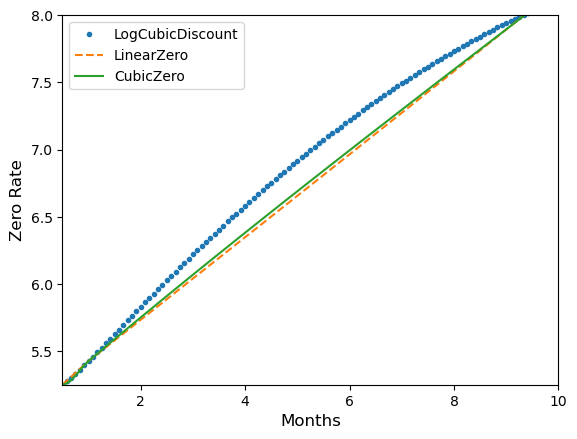

In [11]:
plt.plot(splcd["Maturities"].to_numpy(), splcd["Curve"].to_numpy(), '.', label="LogCubicDiscount");
plt.plot(splz["Maturities"].to_numpy(), splz["Curve"].to_numpy(), '--', label="LinearZero");
plt.plot(spcz["Maturities"].to_numpy() ,spcz["Curve"].to_numpy(), label="CubicZero");
plt.xlabel("Months", size=12)
plt.ylabel("Zero Rate", size=12)
plt.xlim(0.5,10)
plt.ylim([5.25,8])
plt.legend(loc=0);